# Глубокая нейронная сеть для классификации изображений: применение

Необходимо использовать функции, которые были реализованы в предыдущем задании, для построения глубокой сети и применить ее для классификации изображений. Ожидается улучшение точности по сравнению с предыдущей реализацией. 

Начнем!

## Вспомогательные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


## Библиотеки

Давайте сначала импортируем все пакеты, которые вам понадобятся во время этого задания.
- [numpy]
- [matplotlib]
- [h5py](http://www.h5py.org) это пакет для взаимодействия с набором данных, хранящимся в файле H5.
- [PIL](http://www.pythonware.com/products/pil/) и [scipy](https://www.scipy.org/) можно использовать для проверки на собственном изображении.

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Датасет
Вы будете использовать тот же набор данных, что и в первой работе. Построенная в ней модель имела точность 70 % при классификации изображений (cat vs non-cat). 

**Постановка задачи**: 

Имеется набор данных ("data.h5"), содержащий:

     - обучающий набор изображений m_train, помеченных как кошка (1) или не кошка (0)
     - тестовый набор изображений m_test, помеченных как кошка и не кошка
     - каждое изображение имеет форму (num_px, num_px, 3), где 3 соответствует 3 каналам (RGB).

Познакомимся с набором данных поближе. Загрузим данные, запустив ячейку ниже.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Код ниже служит для отображения одного изображения из набора данных. Можно изменять индекс и перезапускать ячейку для ознакомления с данными.

y = 0. It's a non-cat picture.


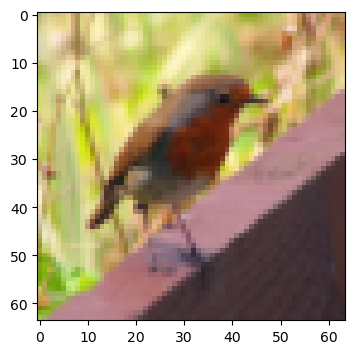

In [4]:
# пример картинки
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# исследуем датасет 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Как обычно, вы изменяете и стандартизируете изображения перед отправкой их в сеть. Код указан в ячейке ниже.

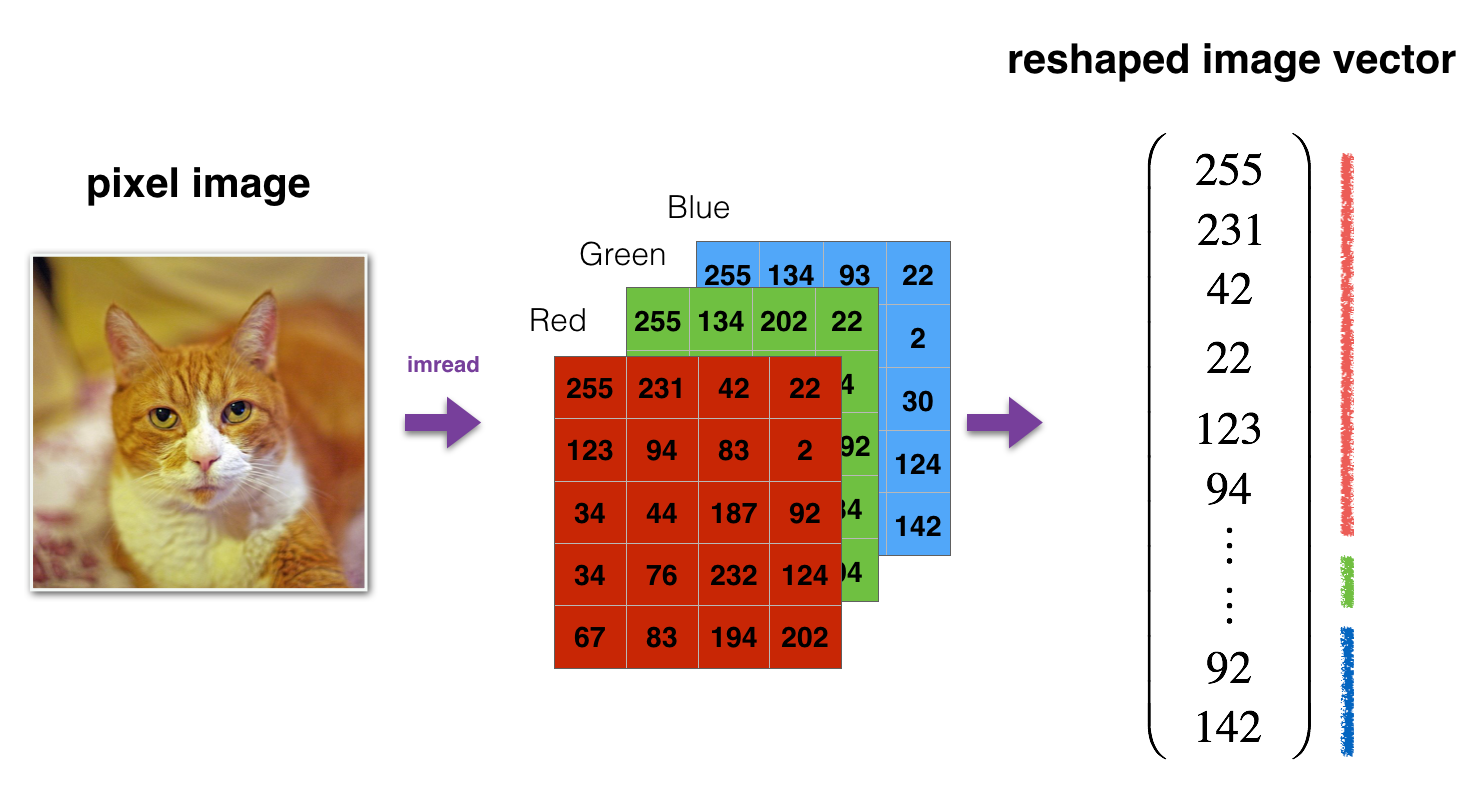

<caption><center> <u>Рисунок 1</u>: Преобразование изображения в вектор. <br> </center></caption>

In [7]:
# Измените размерность обучающих и тестовых элементов
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Стандартизируйте данные, чтобы значения признаков находились в диапазоне от 0 до 1.
train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

print ("train_x: " + str(train_x.shape))
print ("test_x: " + str(test_x.shape))


train_x: (12288, 209)
test_x: (12288, 50)


$12 288$ = $64 \times 64 \times 3$, что соответствует одному вектору изображения.

## Архитектура вашей модели

Теперь, после ознакомления с набором данных, пришло время построить глубокую нейронную сеть, для классификации изображений.

Необходимо построить две разные модели:
- Двухслойная нейронная сеть
- Глубокая нейронная сеть с L слоями.

Затем надо сравнить производительность этих моделей, а также опробовать разные значения $L$.

Давайте посмотрим на две архитектуры.

### 2-слойная нейронная сеть

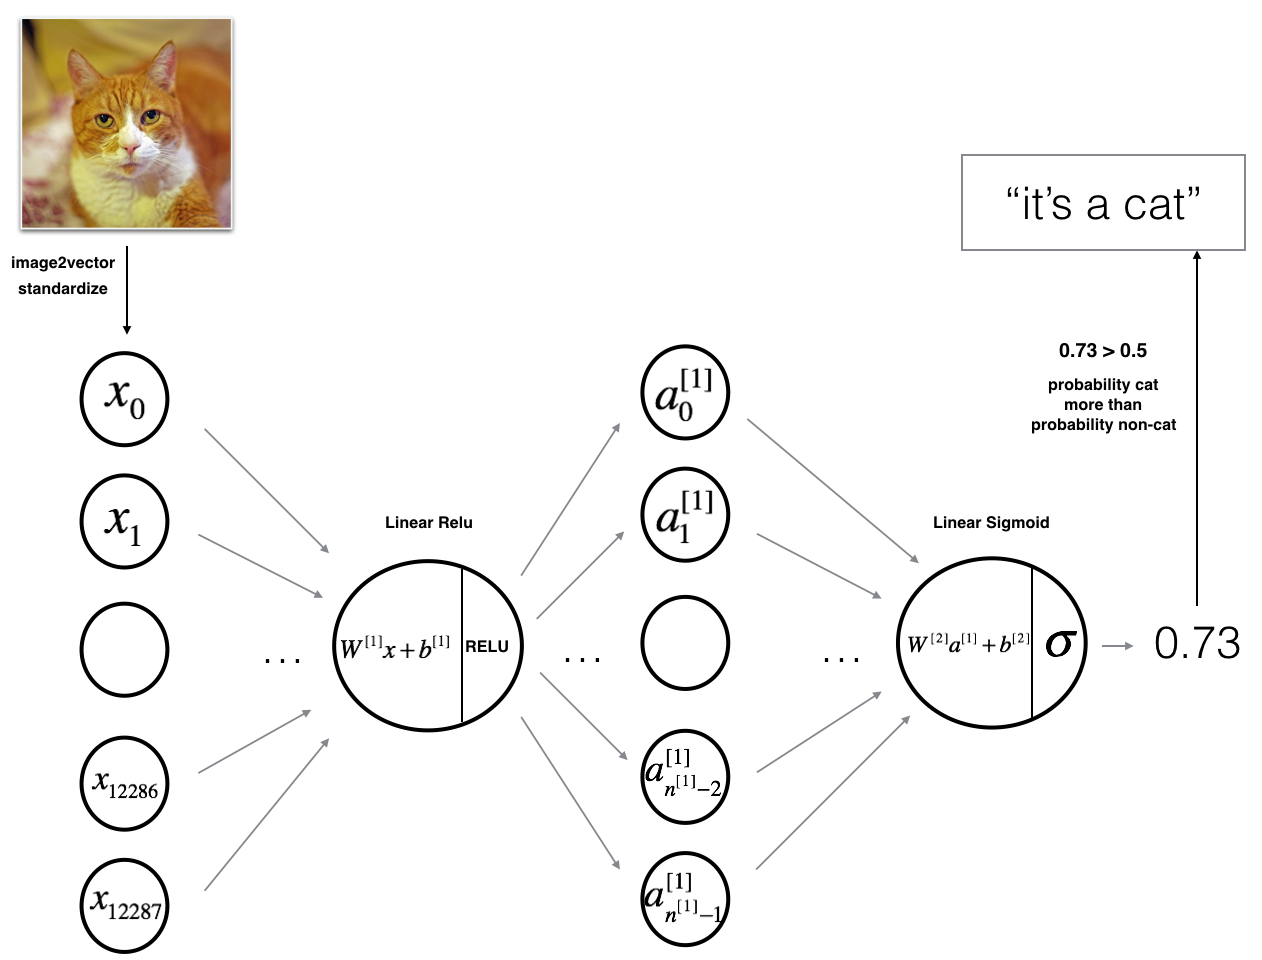
<caption><center> <u>Рисунок 2</u>: 2-слойная нейронная сеть <br> Модель можно описать как: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Детальная архитектура</u>:
- Входные данные представляют собой изображение (64,64,3), преобразованное в вектор с размерностью $(12288,1)$.
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ затем умножается на весовую матрицу $W^{[1]}$ размера $(n^{[1]} , 12288)$.
- Затем добавляется свободный член и используется функция ReLU, чтобы получить следующий вектор: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1 }^{[1]}]^T$.
- Затем процесс повторяется.
- Умножаем полученный вектор на $W^{[2]}$ и добавляем свободный член.
- Наконец, берем sigmoid'у от результата. Если значение больше 0,5, классифицируем изображение как кошку.

### Глубокая нейронная сеть L-слоя

Трудно представить глубокую нейронную сеть L-слоя с помощью приведенного выше описания. Однако вот упрощенное представление сети:

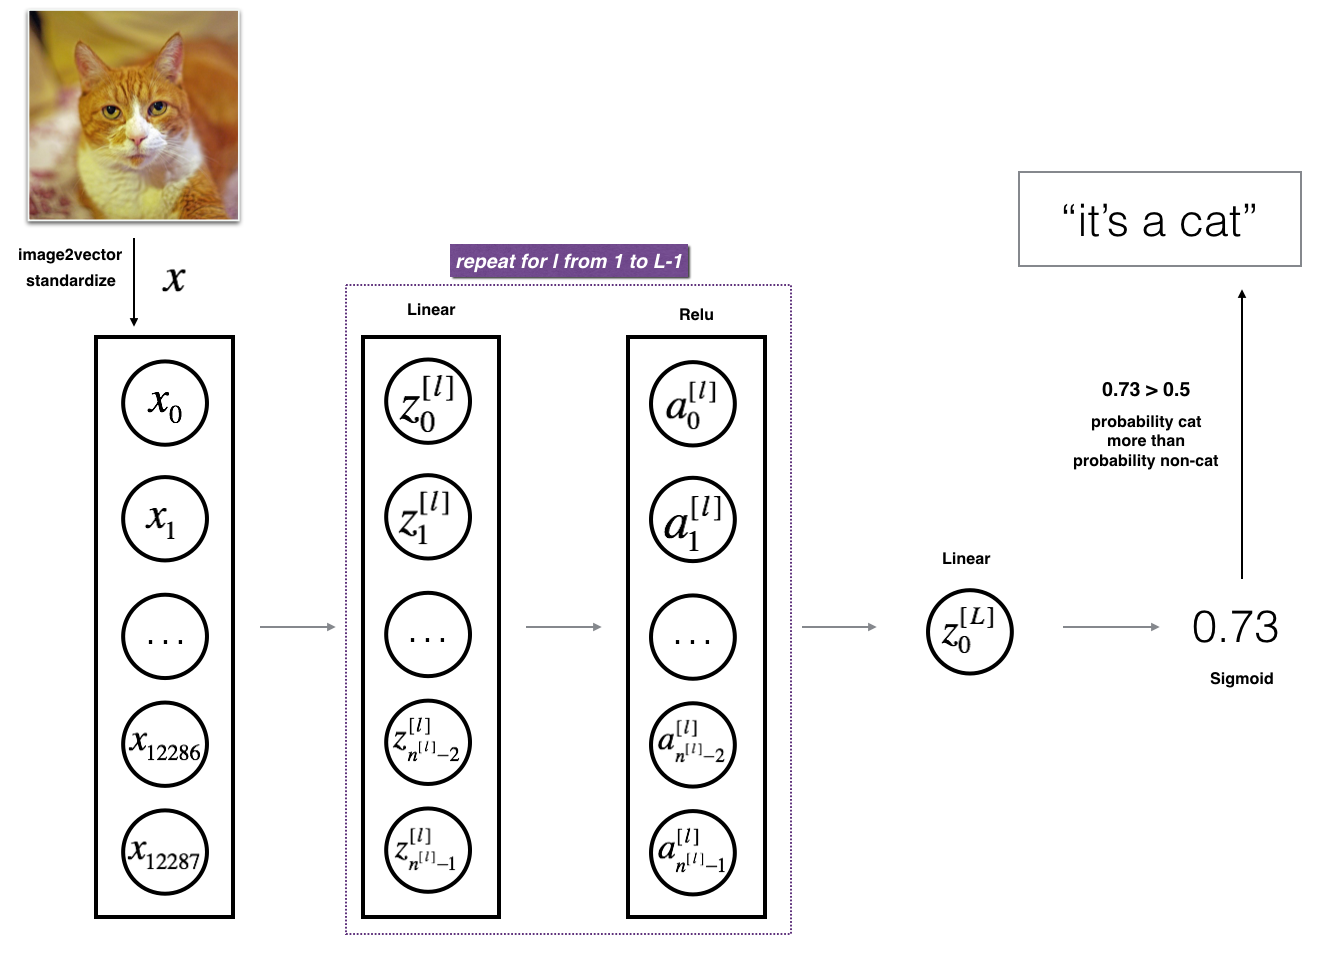
<caption><center> <u>Рисунок 3</u>: L-слойная нейронная сеть. <br> Модель можно описать как: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Детальная архитектура</u>:
- Входные данные представляют собой изображение (64,64,3), преобразованное в вектор с размерностью $(12288,1)$.
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ затем умножается на весовую матрицу $W^{[1]}$, а затем добавляется свободный член $b^{[ 1]}$.
- Далее берём relu от полученного результата. Этот процесс повторяется несколько раз для каждого $(W^{[l]}, b^{[l]})$ в зависимости от архитектуры модели.
- Наконец, берем sigmoid'у от результата. Если получаете больше 0,5, то классифицируем изображение как кошку.

### 3.3 - Общая методология

Как обычно, для построения модели будем следовать методологии глубокого обучения:

     1. Инициализация параметров/Определение гиперпараметров.
     2. Цикл для num_iterations:
         а. Прямое распространение
         б. Вычисление функции стоимости
         в. Обратное распространение
         д. Обновление параметров (с использованием параметров и оценок из кеша)
     4. Использование обученных параметров для прогнозирования меток

Давайте теперь реализуем эти две модели!

## Двухслойная нейронная сеть

**Задание**:  Используйте вспомогательные функции, которые вы реализовали в предыдущем задании, чтобы построить двухслойную нейронную сеть со следующей структурой: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, и их входные данные:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
def initialize_parameters(n_x, n_h, n_y):   
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

def linear_forward(A, W, b):   
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):   
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def compute_cost(AL, Y):   
    m = Y.shape[1]

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def update_parameters(parameters, grads, learning_rate):   
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
        
    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [9]:
### константы, определяющие модель####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [10]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Реализует двухслойную нейронную сеть: LINEAR->RELU->LINEAR->SIGMOID.
    
     Args:
     X — входные данные размерностью (n_x, количество примеров)
     Y — вектор истинных «меток» (содержащий 1, если кошка, 0, если не кошка), формы (1, количество примеров)
     Layers_dims — размеры слоев (n_x, n_h, n_y)
     num_iterations — количество итераций цикла оптимизации
     Learning_rate — скорость обучения правила обновления градиентного спуска.
     print_cost — если установлено значение True, стоимость будет выводиться каждые 100 итераций.
    
     Return:
     параметры — словарь, содержащий W1, W2, b1 и b2.
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              #  чтобы отслеживать cost на всех этапах
    m = X.shape[1]                           # количество элементов
    (n_x, n_h, n_y) = layers_dims
    
    # Инициализируем словарь параметров, вызвав одну из ранее реализованных функций.
    ### Начало кода ### (≈ 1 строка)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### Конец кода ###
    
    # Получите W1, b1, W2 и b2 из словаря parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Цикл (градиентный спуск)

    for i in range(0, num_iterations):

        # Прямое распространение: LINEAR -> RELU -> LINEAR -> SIGMOID. Ввод: "X, W1, b1". Вывод: "A1, cache1, A2, cache2".
        ### Начало кода ### (≈ 2 строчки)
        # Обратите внимание, что cache=(linear_cache, activation_cache),где linear_cache=(A_pre, W, b), activation_cache=z
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### Конец кода ###
        
        # Рассчитаем cost
        ### Начало кода ### (≈ 1 строчка кода)
        cost = compute_cost(A2, Y)
        ### Конец кода ###
        
        # Инициализируем обратное распространение
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Обратное распространение. Ввод: "dA2, cache2, cache1". Вывод: "dA1, dW2, db2; при этом dA0 (не используется), dW1, db1".
        ### Начало кода ### (≈ 2 строчки кода)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### Конец кода ###
        
        # Установим grads['dWl'] равным dW1, grads['db1'] равным db1, grads['dW2'] равным dW2, grads['db2'] равным db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Обновим параметры.
        ### Начало кода ### (примерно 1 строчка кода)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### Конец кода ###

        # Получаем W1, b1, W2, b2 из параметров
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Выводим cost каждые 100 тренировочных экземпляров
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # Построим график

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Запустите ячейку ниже, чтобы обучить параметры нейросети. 
Посмотрите, работает ли ваша модель. Значение функции стоимости должно снижаться. Выполнение 2500 итераций может занять до 5 минут. 

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213017
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556604
Cost after iteration 1600: 0.17080762978096936
Cost after iteration 1700: 0.11306524562164712
Cost after iteration 1800: 0.09629426845937153
Cost after iteration 1900: 0.0834261795972687
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.066307481322

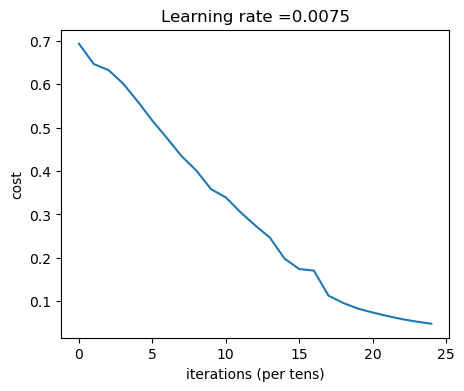

In [11]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Ожидаемый результат**:
<table> 
    <tr>
        <td> **Cost после итерации 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost после итерации 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost после итерации 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Хорошо, что вы создали векторизованную реализацию! В противном случае обучение этому могло бы занять в 10 раз больше времени.

Теперь вы можете использовать обученные параметры для классификации изображений из набора данных. Чтобы увидеть свои прогнозы по обучающим и тестовым наборам, запустите ячейку ниже.

In [12]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Ожидаемый результат**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [13]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Ожидаемый результат**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

Кажется, что двухслойная нейронная сеть имеет лучшую производительность (72%), чем реализация логистической регрессии (70%, вторая неделя задания). Давайте посмотрим, сможем ли мы добиться еще большего с помощью модели $L$-слоев.

## L-слой нейронной сети

**Задание**: Используйте реализованные вами ранее вспомогательные функции для построения нейронной сети $L$-слоя со следующей структурой: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, и их входные данные:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [14]:
def initialize_parameters_deep(layer_dims):    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):   
    m = Y.shape[1]

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads["dA" + str(l + 1)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation="relu")

    return grads

def update_parameters(parameters, grads, learning_rate):   
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
        
    return parameters

In [15]:
### Константы ###
layers_dims = [12288, 20, 7, 5, 1] #  5-слойная модель

In [16]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Реализует нейронную сеть c L слоями: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
     Args:
     X -- данные, массив размерностью (количество примеров, num_px * num_px * 3)
     Y — вектор истинных «меток» (содержащий 0, если кошка, 1, если не кошка), размерностью (1, количество примеров)
     Layers_dims — список, содержащий входной размер и размер каждого слоя длиной (количество слоев + 1).
     Learning_rate — скорость обучения правила обновления градиентного спуска.
     num_iterations — количество итераций цикла оптимизации
     print_cost — если True, cost печатается каждые 100 шагов.
    
     Returns:
     parameters — параметры, изученные моделью. Затем их можно использовать для прогнозирования.
    """

    np.random.seed(1)
    costs = []                         # Отслеживаем значение cost
    
    # Инициализация параметров
    ### Начало кода ###
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### Конец кода ###
    
    # Цикл (градиентный спуск)
    for i in range(0, num_iterations):

        # Прямое распространение: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### Начало кода ### (≈ 1 строчка кода)
        AL, caches = L_model_forward(X, parameters)
        ### Конец кода ###
        
        # Высчитываем cost.
        ### Начало кода ### (≈ 1 строчка кода)
        cost = compute_cost(AL, Y)
        ### Конец кода ###
    
        # Обратное распространение.
        ### Начало кода ### (≈ 1 строчка кода)
        grads = L_model_backward(AL, Y, caches)
        ### Конец кода ###
 
        # Обновление параметров.
        ### Начало кода ### (≈ 1 строчка кода)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### Конец кода ###
                
        # Выводим cost каждые 100 тренировочных экземпляров
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # строим график
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Теперь вы обучите модель как 5-слойную нейронную сеть.

Запустите ячейку ниже, чтобы обучить параметры нейросети. Посмотрите, работает ли ваша модель. Сost должна снизиться. Выполнение 2500 итераций может занять до 5 минут.

Cost after iteration 0: 0.693050
Cost after iteration 100: 0.649815
Cost after iteration 200: 0.642903
Cost after iteration 300: 0.632436
Cost after iteration 400: 0.613634
Cost after iteration 500: 0.588056
Cost after iteration 600: 0.559985
Cost after iteration 700: 0.530796
Cost after iteration 800: 0.500687
Cost after iteration 900: 0.471336
Cost after iteration 1000: 0.441480
Cost after iteration 1100: 0.396495
Cost after iteration 1200: 0.357466
Cost after iteration 1300: 0.321982
Cost after iteration 1400: 0.290850
Cost after iteration 1500: 0.265931
Cost after iteration 1600: 0.240500
Cost after iteration 1700: 0.225170
Cost after iteration 1800: 0.206663
Cost after iteration 1900: 0.187185
Cost after iteration 2000: 0.172662
Cost after iteration 2100: 0.152834
Cost after iteration 2200: 0.135873
Cost after iteration 2300: 0.122784
Cost after iteration 2400: 0.113169


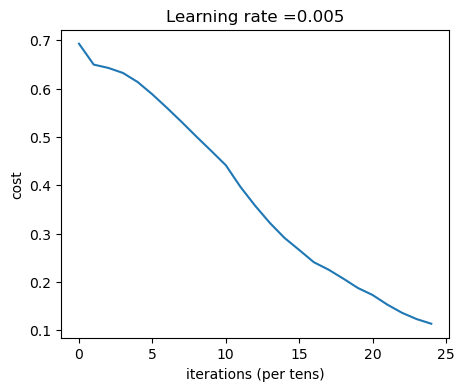

In [17]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost после итерации 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost после итерации 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost после итерации 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [18]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9760765550239232


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [20]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Ожидаемый результат**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Кажется, что 5-слойная нейронная сеть имеет лучшую производительность (80%), чем 2-слойная нейронная сеть (72%) на том же тестовом наборе.

Это хороший результат для данной задачи!

## Анализ результатов

Посмотрим на некоторые изображения, которые L-слойная модель пометила неправильно.

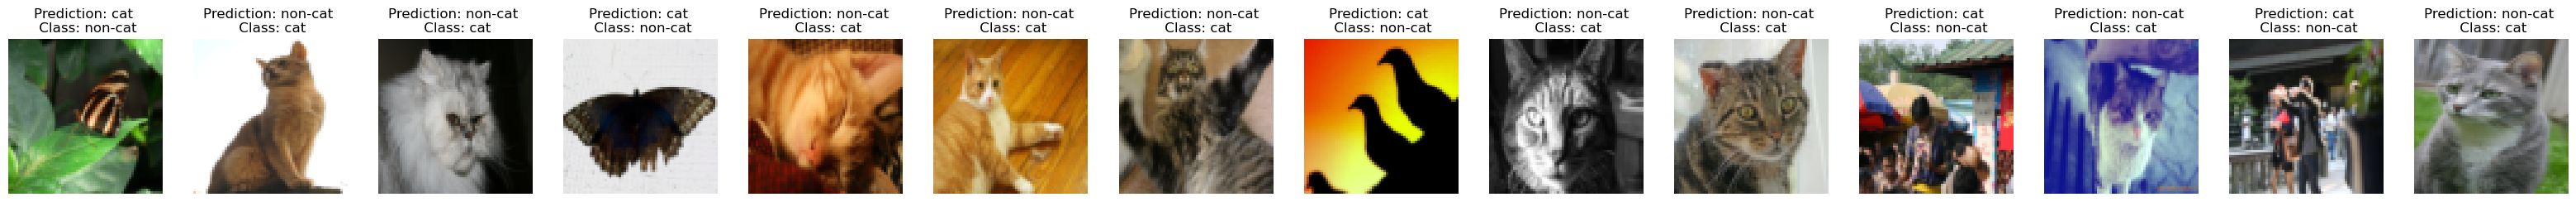

In [21]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Некоторые типы изображений, на которых модель обычно плохо работает:**

- Тело кошки в необычном положении
- Кот на фоне аналогичного цвета
- Необычный окрас и вид кошек
- Необычный угол съемки
- Яркость изображения
- Изменение масштаба (на изображении кот очень большой или маленький)